# Error-correcting codes

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
np.random.seed(5)

A message consists of a number of bits $N_{\text{bits}}$.

We can arrange these bits in some number of groups of some size that is a power of two, e.g. $2^4=16$:

$
\text{message} = 
\begin{bmatrix}
    1 & 0 & 0 & 1 \\
    0 & 1 & 0 & 0 \\
    0 & 1 & 0 & 1 \\
    1 & 0 & 1 & 1 \\
\end{bmatrix}
$

Error-correction deals with detecting whether a message like the above has been corrupted by an error, which manifests themselves as bit-flips, identifying which bit(s) was corrupted and correcting it(them).

This can be achieved by letting some if the bits in the message be so-called **parity-bits**. These bits no longer represent information from the message that we want to transmit but instead represent the **parity** of the associated **parity group**.

Applying the XOR operation on multiple bit strings is equavalent to computing the parity of the groups in the columns.


For example, arrange the following paraity groups
    00100
    01101
    01010
     

in columns and apply the XOR:
```
    00001001
    01111110
    11011111
    00111011
    01011010
    –––––––––
    11001001
```


In [3]:
# First, we set the number of bits we consider to have in our Hamming blocks
BLOCK_SIZE = 16
BLOCK_WIDTH = np.sqrt(BLOCK_SIZE).astype(int)

assert BLOCK_SIZE == BLOCK_WIDTH ** 2

In [4]:
grey = [0.54509804, 0.54509804, 0.54509804]
red = [0.98823529, 0.45098039, 0.36862745]
yellow = [0.81960784, 0.83137255, 0.16470588]
blue = [0.29411765, 0.57254902, 0.64313725]
black = [0.0, 0.0, 0.0]
white = [1.0, 1.0, 1.0]

grey_arr = np.array(grey)
red_arr = np.array(red)
yellow_arr = np.array(yellow)
blue_arr = np.array(blue)
black_arr = np.array(black)

img_size = (10, 10)
blue_img = (np.ones((*img_size, 3)) * blue_arr[None, None, :])
black_img = (np.ones((*img_size, 3)) * black_arr[None, None, :])


def visualize_block(block, error_index=None, block_width=BLOCK_WIDTH):
    if error_index is None or isinstance(error_index, int):
        error_index = [error_index]

    fig = plt.figure(figsize=(block_width, block_width))

    for i in range(block_width * block_width):
        plt.subplot(block_width, block_width, i + 1)

        if i in error_index:
            img = black_img
        else:
            img = blue_img if block[i] else black_img

        plt.imshow(img, vmin=0, vmax=1, interpolation='none')
        ax = plt.gca()
        
        ax.tick_params(
            axis="both",
            which="both",  # both major and minor ticks are affected
            left=False,  # ticks are off on all edges
            right=False,
            bottom=False,
            top=False,
            labelleft=False,  # labels are off on all edges
            labelbottom=False,
        )
        plt.subplots_adjust(top=1, bottom=0, left=0, right=1, wspace=0.0, hspace=0.0)

        # Block message value
        if i in error_index:
            color = red
        elif is_power_of_two(i):
            color = yellow
        else:
            color = white
        ax.text(
            x=0.5,
            y=0.6,
            s=f'{block[i]}',
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=36,
            transform=ax.transAxes,
            color=color
        )

        # Bit index
        ax.text(
            x=0.03,
            y=0.97,
            s=f'{i}',
            horizontalalignment='left',
            verticalalignment='top',
            fontsize=14,
            transform=ax.transAxes,
            color='white'
        )

        # Bit index (binary value)
        s = ''.join([str(v) for v in int_to_binary(i)])
        ax.text(
            x=0.5,
            y=0.15,
            s=f"{s}",
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=16,
            transform=ax.transAxes,
            color='white'
        )

In [5]:
def int_to_binary(v: int, bits: int = 4):
    """Given an integer, return the pure binary representation
    as a list of integers of fixed length 'bits'.
    """
    return [(v >> i) & 1 for i in range(bits - 1, -1, -1)]

## Forming the message

In [6]:
# Let us now draw a random message
message = np.random.randint(0, 2, size=100)
message

array([1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1])

In [7]:
def get_number_of_parity_bits(BLOCK_SIZE: int, extended_hamming_code=True):
    """Return the number of parity bits in a Hamming message block"""
    return np.log2(BLOCK_SIZE).astype(int) + extended_hamming_code

In [8]:
def get_number_of_message_bits(BLOCK_SIZE: int, extended_hamming_code=True):
    """Return the number of message bits in a Hamming message block"""
    parity_bits = get_number_of_parity_bits(BLOCK_SIZE, extended_hamming_code=extended_hamming_code)
    return BLOCK_SIZE - parity_bits

In [9]:
# Select the part of the message that we want to put in the first block
i = 0
n_message_bits = get_number_of_message_bits(BLOCK_SIZE)
block_message = message[i:i + n_message_bits]
print(block_message)

[1 0 1 1 0 0 0 1 0 0 1]


In [10]:
def is_power_of_two(n: int):
    """
    Every power of 2 has exactly 1 bit set to 1
    (the bit in that number's log base-2 index).
    So when subtracting 1 from it, that bit flips
    to 0 and all preceding bits flip to 1. 
    That makes these 2 numbers the inverse of
    each other so when AND-ing them, we will get
    0 as the result.
    """
    return n != 0 and (n & (n-1) == 0)

In [11]:
def get_message_locations(BLOCK_SIZE: int, extended_hamming_code=True):
    """Get message bit locations in the Hamming message block leaving parity bits untouched"""
    if extended_hamming_code:
        [i for i in range(BLOCK_SIZE) if not is_power_of_two(i)]
    return [i for i in range(1, BLOCK_SIZE) if not is_power_of_two(i)]

In [12]:
message_locations = get_message_locations(BLOCK_SIZE)
message_locations

[3, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15]

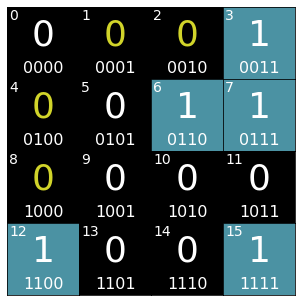

In [13]:
# Set the message bits in the Hamming block
block = np.zeros(BLOCK_SIZE, dtype=np.uint8)
block[message_locations] = block_message
visualize_block(block)

In [14]:
from functools import reduce
import operator

def xor(x, y):
    return x ^ y

def check_parity_groups(block):
    """Given a hamming block, check it for any errors."""
    locations_of_one_bits = [i for i, bit in enumerate(block) if bit]
    return reduce(xor, locations_of_one_bits)

def is_meta_parity_ok(block):
    """Given a hamming block, check the full block parity bit for two-bit errors"""
    is_ok = block.sum() % 2 == 0
    return is_ok

def extended_hamming_check(block):
    """Do an extended Hamming code check on the given block

    Returns whether there were 0, 1 or 2-or-more errors and 
    the location of the error (if only one error is present).
    """
    error_index = check_parity_groups(block)
    atleast_one_error = error_index != 0

    meta_ok = not is_meta_parity_ok(block)
    two_errors_or_more = atleast_one_error and not meta_ok

    if two_errors_or_more:
        return dict(errors=2, location=None)
    elif atleast_one_error:
        return dict(errors=1, location=error_index)
    return dict(errors=0, location=None)


In [15]:
# Check the block for errors (so that we can set the parity bits correctly)
error_bit = check_parity_groups(block)
error_bit

1

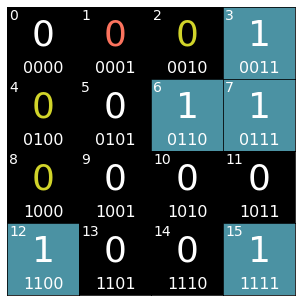

In [16]:
visualize_block(block, error_index=error_bit)

In [17]:
# Now we set the parity bits via a the key observation that the index of a bit
# in the block, represented in binary, exactly gives us which parity groups are
# affected by that value.
# This is the case because of the way we placed the parity bits in the array at
# index locations that are powers of 2.
# Hence, we know that e.g. location 14 (1110) affects parity groups 1, 2 and 3
# but not 0. The parity bits to flip are therefore 2^1, 2^2 abd 2^3.

In [18]:
# The error represented in binary indicates which parity group bits we need to flip.
# Specifically, read as binary, from left to right, if the i'th bit is one
# this indicates that the i'th parity bit should be flipped, i.e. index 2**i in the
# Hamming block.
error_bit_binary = int_to_binary(error_bit)
error_bit_binary

[0, 0, 0, 1]

In [19]:
parity_locations_to_flip = [2 ** i for i, bit in enumerate(reversed(error_bit_binary)) if bit]
parity_locations_to_flip

[1]

In [20]:
block[parity_locations_to_flip] ^= 1  # Bit shift to flip bits

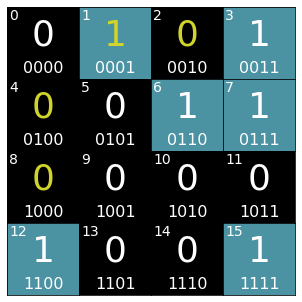

In [21]:
visualize_block(block)

In [22]:
# Now we set the whole block parity bit such that the parity of
# the whole block is even
flip_whole_block_parity = not is_meta_parity_ok(block)
block[0] = int(flip_whole_block_parity)

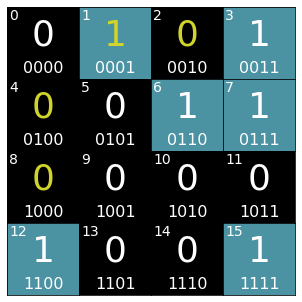

In [23]:
visualize_block(block)

In [24]:
# Now there are no erroroneous bits and the block is
# well-formed, ready to send
error_bit = check_parity_groups(block)
error_bit_binary = int_to_binary(error_bit)
print(error_bit, error_bit_binary)
assert error_bit == 0

0 [0, 0, 0, 0]


## Sending the message

### One error

In [25]:
# Now, let's send the block containing the first bits of the message.
# However, we will simulate a random bit flip happening along the channel.
flip_index = np.random.choice(len(block))
block[flip_index] = not block[flip_index]
flip_index

8

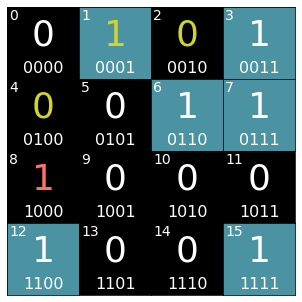

In [26]:
visualize_block(block, error_index=flip_index)

In [27]:
# The receiver now simply checks the block to discover the flipped bit
error_index = check_parity_groups(block)
error_index, is_meta_parity_ok(block)

(8, False)

In [28]:
extended_hamming_check(block)

{'errors': 1, 'location': 8}

In [29]:
# Since there is an error and the whole block parity check is False
# we know that there is 1 error (or more than 2).

In [30]:
# Assuming there was one error, fix it to recover the original message
block[error_index] = not block[error_index]

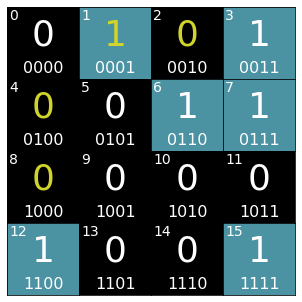

In [31]:
visualize_block(block)

### Two errors

In [32]:
# Let's send a message with two random bits flipped
flip_index = np.random.choice(len(block), size=2, replace=False)
block[flip_index] ^= 1
flip_index

array([1, 9])

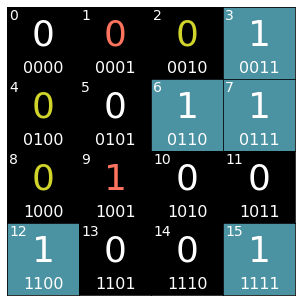

In [33]:
visualize_block(block, error_index=flip_index)

In [34]:
# The receiver now simply checks the block to discover the flipped bit
error_index = check_parity_groups(block)
error_index, is_meta_parity_ok(block)

(8, True)

In [35]:
extended_hamming_check(block)

{'errors': 2, 'location': None}

In [36]:
# Since the whole block parity bit is OK but there is an error bit, 
# we know that at least two errors occured but in this case we cannot
# recover them with Hamming coding.